In [1]:
import pandas as pd
cal = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
steval = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv')
price = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv') 

Since the set of full training labels are released now, we can ignore "sales_train_validation" data set and proceed working with "sales_train_evaluation" instead. We will check some randomly selected id's trend now, just to get a view of how it is varying with time.

In [2]:
import numpy as np
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

id_list = sorted(list(set(steval['id'])))
d_cols = [col for col in steval.columns if 'd_' in col]
x_1 = steval.loc[steval['id'] == id_list[0]].set_index('id')[d_cols].values[0][:200]
x_2 = steval.loc[steval['id'] == id_list[12]].set_index('id')[d_cols].values[0][300:500]
x_3 = steval.loc[steval['id'] == id_list[36]].set_index('id')[d_cols].values[0][600:800]
x_4 = steval.loc[steval['id'] == id_list[64]].set_index('id')[d_cols].values[0][1000:1200]
x_5 = steval.loc[steval['id'] == id_list[128]].set_index('id')[d_cols].values[0][1300:1500]
x_6 = steval.loc[steval['id'] == id_list[256]].set_index('id')[d_cols].values[0][1600:1800]
fig = make_subplots(rows=6, cols=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_1)), y=x_1, showlegend=True, 
                         mode='lines', name="1st sample",
                         marker=dict(color="cadetblue")), row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_2)), y=x_2, showlegend=True,
                         mode='lines', name="2nd sample",
                         marker=dict(color="firebrick")), row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_3)), y=x_3, showlegend=True,
                         mode='lines', name="3rd sample",
                         marker=dict(color="yellowgreen")), row=3, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_4)), y=x_4, showlegend=True,
                         mode='lines', name="4th sample",
                         marker=dict(color="orangered")), row=4, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_5)), y=x_5, showlegend=True,
                         mode='lines', name="5th sample",
                         marker=dict(color="mediumpurple")), row=5, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_6)), y=x_6, showlegend=True,
                         mode='lines', name="6th sample", 
                         marker=dict(color="navy")), row=6, col=1)

fig.update_layout(height=1200, width=800, title_text="Observing some randomly chosen sales trend :")
fig.show()

By observation, we can spot intermittency in all the samples, especially in second and fourth samples, intermittency can be spotted very prominently (Y-axis value is dropping to zero quite frequently).

In [3]:
steval.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


We see that evaluation data set has columns from "d_1" till "d_1941". Since we need to get the result for next 28 days i.e. from "d_1942" till "d_1969", we can fill them up with zero values, initially.

In [4]:
#For the remaining 28 days d1942 to d1969, filling with zero

import numpy as np
for i in range(1942,1970):
    col = 'd_' + str(i)
    steval[col] = 0
    steval[col] = steval[col].astype(np.int16)

Now, we will check the sizes of three datasets and reduce them to avoid getting memory allocation alert.

In [5]:
#Check size
steval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1975 entries, id to d_1969
dtypes: int16(28), int64(1941), object(6)
memory usage: 454.5+ MB


In [6]:
#Check size
cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


In [7]:
#Check size
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


We will now reduce the sizes of three datasets.

In [8]:
# Taken from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
import numpy as np
def reduce_mem_usage(df):
   
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [9]:
reduce_mem_usage(steval)

Memory usage of dataframe is 454.54 MB
Memory usage after optimization is: 97.37 MB
Decreased by 78.6%


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,0,0,0,0,0,0,0,0,0,0
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,0,0,0,0,0,0,0,0
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
reduce_mem_usage(price)

Memory usage of dataframe is 208.77 MB
Memory usage after optimization is: 45.77 MB
Decreased by 78.1%


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.000000
6841117,WI_3,FOODS_3_827,11618,1.000000
6841118,WI_3,FOODS_3_827,11619,1.000000
6841119,WI_3,FOODS_3_827,11620,1.000000


In [11]:
reduce_mem_usage(cal)

Memory usage of dataframe is 0.21 MB
Memory usage after optimization is: 0.22 MB
Decreased by -5.7%


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


For day indicators (variables with prefix "d_") in "steval" data set, the values can be more conveniently handled if they are reshaped to put into rows instead of columns. Because in the next step, we will actually merge the "steval" dataset with two other data sets (calendar and prices); and notably, in "calendar" data set, the column "d" has "d_" prefixed values arranged in vertical format (unlike "steval" where they are arranged horizontally). So, we will apply "melt" function on "steval" which will unpivot the dataframe from wide format (horizontal) to long format (vertical). This will help in merging the data set with calendar data set. 

In [12]:
sales = pd.melt(steval, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()

Now, the sales dataframe looks like below, compact, easy to merge with Calendar data set matched on column "d".

In [13]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


Next, we will merge calendar and price datasets with sales data to make it a single working data set.

In [14]:
sales = pd.merge(sales, cal, on='d', how='left')
sales = pd.merge(sales, price, on=['store_id','item_id','wm_yr_wk'], how='left') 

Checking all the columns in our final working data set :

In [15]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60034810 entries, 0 to 60034809
Data columns (total 22 columns):
 #   Column        Dtype   
---  ------        -----   
 0   id            category
 1   item_id       category
 2   dept_id       category
 3   cat_id        category
 4   store_id      category
 5   state_id      category
 6   d             object  
 7   sold          int16   
 8   date          category
 9   wm_yr_wk      int16   
 10  weekday       category
 11  wday          int8    
 12  month         int8    
 13  year          int16   
 14  event_name_1  category
 15  event_type_1  category
 16  event_name_2  category
 17  event_type_2  category
 18  snap_CA       int8    
 19  snap_TX       int8    
 20  snap_WI       int8    
 21  sell_price    float16 
dtypes: category(12), float16(1), int16(3), int8(5), object(1)
memory usage: 2.5+ GB


We will encode the categorical variables to numericals. And for convenience, we will store their categories (a list) along with their codes (another list) in separate dictionaries, so that we can use them again during submission.

In [16]:
#Encode categorical variables. Store the categories along with their codes
d_id = dict(zip(sales.id.cat.codes, sales.id))
d_item_id = dict(zip(sales.item_id.cat.codes, sales.item_id))
d_dept_id = dict(zip(sales.dept_id.cat.codes, sales.dept_id))
d_cat_id = dict(zip(sales.cat_id.cat.codes, sales.cat_id))
d_store_id = dict(zip(sales.store_id.cat.codes, sales.store_id))
d_state_id = dict(zip(sales.state_id.cat.codes, sales.state_id))

In [17]:
#Removing "d_" prefix from the values of column "d"
sales.d = sales['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)
cols = sales.dtypes.index.tolist()
types = sales.dtypes.values.tolist()
for i,type in enumerate(types):
    if type.name == 'category':
        sales[cols[i]] = sales[cols[i]].cat.codes

In [18]:
#Dropping date column        
sales.drop('date',axis=1,inplace=True)

Now, we will introduce lags into this data set. I have introduced lags at a sequence {2^0,2^1,2^2,2^3,2^4,2^5}. You can introduce lags at some other sequence like {1,3,6,12,24,36} etc.

In [19]:
lags = [1,2,4,8,16,32]
for lag in lags:
    sales['sold_lag_'+str(lag)] = sales.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['sold'].shift(lag).astype(np.float16)

In [20]:
#Combination of two vars with "sold" and their mean
sales['item_sold_avg'] = sales.groupby('item_id')['sold'].transform('mean').astype(np.float16)
sales['state_sold_avg'] = sales.groupby('state_id')['sold'].transform('mean').astype(np.float16)
sales['store_sold_avg'] = sales.groupby('store_id')['sold'].transform('mean').astype(np.float16)
sales['cat_sold_avg'] = sales.groupby('cat_id')['sold'].transform('mean').astype(np.float16)
sales['dept_sold_avg'] = sales.groupby('dept_id')['sold'].transform('mean').astype(np.float16)

#Combination of three vars with "sold" and their mean
sales['cat_dept_sold_avg'] = sales.groupby(['cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
sales['store_item_sold_avg'] = sales.groupby(['store_id','item_id'])['sold'].transform('mean').astype(np.float16)
sales['cat_item_sold_avg'] = sales.groupby(['cat_id','item_id'])['sold'].transform('mean').astype(np.float16)
sales['dept_item_sold_avg'] = sales.groupby(['dept_id','item_id'])['sold'].transform('mean').astype(np.float16)
sales['dept_store_sold_avg'] = sales.groupby(['dept_id','store_id'])['sold'].transform('mean').astype(np.float16)

#Combination of four vars with "sold" and their mean
sales['store_cat_dept_sold_avg'] = sales.groupby(['store_id','cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
sales['store_cat_item_sold_avg'] = sales.groupby(['store_id','cat_id','item_id'])['sold'].transform('mean').astype(np.float16)

#Some more combinations can be incorporated here, but to avoid memory allocation warning, the above combinations would suffice 

In [21]:
id_list = sorted(list(set(sales['id'])))
sold_avg_cols = [col for col in sales.columns if '_sold_avg' in col]
x_1 = sales.loc[sales['id'] == id_list[0]].set_index('id')[sold_avg_cols].values[0][:]
x_2 = sales.loc[sales['id'] == id_list[12]].set_index('id')[sold_avg_cols].values[0][:]
x_3 = sales.loc[sales['id'] == id_list[36]].set_index('id')[sold_avg_cols].values[0][:]
x_4 = sales.loc[sales['id'] == id_list[64]].set_index('id')[sold_avg_cols].values[0][:]
x_5 = sales.loc[sales['id'] == id_list[128]].set_index('id')[sold_avg_cols].values[0][:]
x_6 = sales.loc[sales['id'] == id_list[256]].set_index('id')[sold_avg_cols].values[0][:]
fig = make_subplots(rows=6, cols=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_1)), y=x_1, showlegend=True, 
                         mode='lines+markers', name="First sample",
                         marker=dict(color="cadetblue")), row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_2)), y=x_2, showlegend=True,
                         mode='lines+markers', name="Second sample",
                         marker=dict(color="firebrick")), row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_3)), y=x_3, showlegend=True,
                         mode='lines+markers', name="Third sample",
                         marker=dict(color="yellowgreen")), row=3, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_4)), y=x_4, showlegend=True,
                         mode='lines+markers', name="Fourth sample",
                         marker=dict(color="orangered")), row=4, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_5)), y=x_5, showlegend=True,
                         mode='lines+markers', name="Fifth sample",
                         marker=dict(color="mediumpurple")), row=5, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_6)), y=x_6, showlegend=True,
                         mode='lines+markers', name="Sixth sample", 
                         marker=dict(color="navy")), row=6, col=1)

fig.update_layout(height=1200, width=800, title_text="Observing some randomly chosen '_sold_avg' trends after applying lag:")
fig.show()

Now, we can spot some similarity. First, second, fourth, fifth samples show somewhat similar trend now. Third and sixth ones show similar trends as well.

Now, we will use **"rolling window"** and **"expanding window"** concepts where the sold-mean of a particular window size will be stored in two different variables. It is important to decide the size of rolling window (for getting Moving Average). Longer the rolling window size, smoother the rolling window mean estimates become. For deciding expanding window size, suppose, the number of increments between successive rolling windows is 1 period; then it partitions the entire data set into N = T – m + 1 subsamples (ref: the picture below)
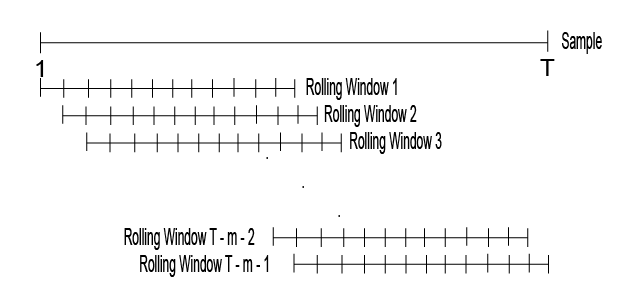

(pic taken from mathworks.com). Here, we have taken window size = 6 and expanding window size = 2 respectively.

In [22]:
sales['rolling_sold_mean'] = sales.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.rolling(window=6).mean()).astype(np.float16)

In [23]:
sales['expanding_sold_mean'] = sales.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.expanding(2).mean()).astype(np.float16)

In [24]:
#Clear some space
import gc
gc.collect()

22

In [25]:
# Moving Average Trends
sales['daily_avg_sold'] = sales.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d'])['sold'].transform('mean').astype(np.float16)
sales['avg_sold'] = sales.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform('mean').astype(np.float16)
sales['selling_trend'] = (sales['daily_avg_sold'] - sales['avg_sold']).astype(np.float16)
sales.drop(['daily_avg_sold','avg_sold'],axis=1,inplace=True)

In [26]:
# Since we introduced lags till 32 days, data for first 31 days should be removed.
sales = sales[sales['d']>=32]

In [27]:
import gc
gc.collect()

44

In [28]:
# Save data for training
sales.to_pickle('salesdata.pkl') #to_pickle: serializes an object to file
del sales

In [29]:
gc.collect()

22

In [30]:
data = pd.read_pickle('salesdata.pkl')
validation = data[(data['d']>=1914) & (data['d']<1942)][['id','d','sold']]
test = data[data['d']>=1942][['id','d','sold']]
eval_prediction = test['sold']
validation_prediction = validation['sold']

In [31]:
gc.collect()

44

In [32]:
#Get the store ids
stores = steval.store_id.cat.codes.unique().tolist()
for store in stores:
    df = data[data['store_id']==store]

In [33]:
gc.collect()

44

In [34]:
#Split the data
X_train, y_train = df[df['d']<1914].drop('sold',axis=1), df[df['d']<1914]['sold']
X_valid, y_valid = df[(df['d']>=1914) & (df['d']<1942)].drop('sold',axis=1), df[(df['d']>=1914) & (df['d']<1942)]['sold']
X_test = df[df['d']>=1942].drop('sold',axis=1)

In [35]:
gc.collect()

44

We will use LightGBM regressor model to train data. For getting the best set of hyperparameters for the LightGBM regressor, we will use **hyperopt** for tuning.

In [36]:
from lightgbm import LGBMRegressor as lgb
from hyperopt import hp, tpe, fmin
from sklearn.model_selection import cross_val_score

valgrid = {'n_estimators':hp.quniform('n_estimators', 900, 1200, 100),
           'learning_rate':hp.quniform('learning_rate', 0.1, 0.4, 0.1),
           'max_depth':hp.quniform('max_depth', 4,8,1),
           'num_leaves':hp.quniform('num_leaves', 25,75,25),
           'subsample':hp.quniform('subsample', 0.5, 0.9, 0.1),
           'colsample_bytree':hp.quniform('colsample_bytree', 0.5, 0.9, 0.1),
           'min_child_weight':hp.quniform('min_child_weight', 200, 500, 100) 
          }

def objective(params):
    params = {'n_estimators': int(params['n_estimators']),
              'learning_rate': params['learning_rate'],
              'max_depth': int(params['max_depth']),
              'num_leaves': int(params['num_leaves']),
              'subsample': params['subsample'],
              'colsample_bytree': params['colsample_bytree'],
              'min_child_weight': params['min_child_weight']}
    
    lgb_a = lgb(**params)
    score = cross_val_score(lgb_a, X_train, y_train, cv=2, n_jobs=-1).mean()
    return score

bestP = fmin(fn= objective, space= valgrid, max_evals=20, rstate=np.random.RandomState(123), algo=tpe.suggest)

 20%|██        | 4/20 [36:54<2:26:02, 547.66s/trial, best loss: 0.951556032272774]

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.




100%|██████████| 20/20 [3:00:34<00:00, 541.72s/trial, best loss: 0.9510349613776001]  


In [37]:
gc.collect()

85

We will now apply LightGBM regressor with the best parameters to get the prediction results.

In [38]:
print(bestP)

{'colsample_bytree': 0.8, 'learning_rate': 0.4, 'max_depth': 5.0, 'min_child_weight': 400.0, 'n_estimators': 1000.0, 'num_leaves': 25.0, 'subsample': 0.6000000000000001}


In [39]:
import lightgbm

model = lightgbm.LGBMRegressor(
        n_estimators = int(bestP['n_estimators']),
        learning_rate = bestP['learning_rate'],
        subsample = bestP['subsample'],
        colsample_bytree = bestP['colsample_bytree'],
        max_depth = int(bestP['max_depth']),
        num_leaves = int(bestP['num_leaves']),
        min_child_weight = int(bestP['min_child_weight']))

print('Prediction for Store: {}**'.format(d_store_id[store]))
model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)], eval_metric='rmse', verbose=20, early_stopping_rounds=20)
validation_prediction[X_valid.index] = model.predict(X_valid)
eval_prediction[X_test.index] = model.predict(X_test)
filename = 'model'+str(d_store_id[store])+'.pkl'

Prediction for Store: WI_3**
Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 0.845401	training's l2: 0.714703	valid_1's rmse: 0.598143	valid_1's l2: 0.357775
[40]	training's rmse: 0.800682	training's l2: 0.641092	valid_1's rmse: 0.563927	valid_1's l2: 0.318013
[60]	training's rmse: 0.782921	training's l2: 0.612965	valid_1's rmse: 0.562789	valid_1's l2: 0.316731
[80]	training's rmse: 0.767014	training's l2: 0.58831	valid_1's rmse: 0.554536	valid_1's l2: 0.30751
[100]	training's rmse: 0.755899	training's l2: 0.571383	valid_1's rmse: 0.548914	valid_1's l2: 0.301306
[120]	training's rmse: 0.748963	training's l2: 0.560945	valid_1's rmse: 0.544638	valid_1's l2: 0.296631
Early stopping, best iteration is:
[107]	training's rmse: 0.751803	training's l2: 0.565207	valid_1's rmse: 0.543882	valid_1's l2: 0.295807


We will now save the model.

In [40]:
import joblib

joblib.dump(model, filename)
del model, X_train, y_train, X_valid, y_valid
gc.collect()

2

In [41]:
# Validation results 
validation = steval[['id']+['d_' + str(i) for i in range(1914,1942)]]
validation['id']=pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv').id
validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]

# Evaluation results
test['sold'] = eval_prediction
evaluation = test[['id','d','sold']]
evaluation = pd.pivot(evaluation, index='id', columns='d', values='sold').reset_index()
evaluation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]

# Mapping category ids to their categories
evaluation.id = evaluation.id.map(d_id)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [42]:
gc.collect()

22

In [43]:
# Check submission file
submit = pd.concat([validation,evaluation]).reset_index(drop=True)
submit.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.0,0.0,0.0,2.0,0.0,3.0,5.0,0.0,0.0,...,2.0,4.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,1.0
1,HOBBIES_1_002_CA_1_validation,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,HOBBIES_1_003_CA_1_validation,0.0,0.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0,...,1.0,0.0,2.0,0.0,0.0,0.0,2.0,3.0,0.0,1.0
3,HOBBIES_1_004_CA_1_validation,0.0,0.0,1.0,2.0,4.0,1.0,6.0,4.0,0.0,...,1.0,1.0,0.0,4.0,0.0,1.0,3.0,0.0,2.0,6.0
4,HOBBIES_1_005_CA_1_validation,1.0,0.0,2.0,3.0,1.0,0.0,3.0,2.0,3.0,...,0.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,1.0,0.0


In [44]:
# Submission
submit.to_csv('submission.csv',index=False)
print("Submission successful")

Submission successful
